In [134]:
from bs4 import BeautifulSoup as soup

import requests
import time
import random

search_text = "unity3d"

In [135]:
import re

def wait ():
    sleep_time = {'min': 0.1, 'max': 0.5}
    time.sleep(sleep_time["min"]+(random.random()*(sleep_time["max"]-sleep_time["min"])))

url = "https://nn.hh.ru/search/vacancy"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:91.0) Firefox/91.0",
    "Accept": "*/*",
    "Accept-Language": "ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3",
    "Connection": "keep-alive"
}

params = {
    "clusters": False,
    "ored_clusters": False,
    "enable_snippets": False,
    "salary": None,
    "st": "searchVacancy",
    "text": search_text,
    "page": 0
}

def get_max_page_count():
    
    response = requests.get(url, headers = headers, params = params)
    response_parsed = soup(response.text, 'html.parser')
    

    pager_buttons = response_parsed.select("div[data-qa='pager-block'] a[class='bloko-button'][data-qa='pager-page']")  
    
    max_page_number = 0
    
    for pager_button in (pager_buttons or []):
        number = int(pager_button.get_text())
        max_page_number = number if number > max_page_number else max_page_number
        
    wait()
    print("max page count: ",max_page_number)
    return max_page_number


vacancys_data = []
vacancys_on_page = False 
vacancys_page_count = get_max_page_count()

while params['page'] < vacancys_page_count:
    
    while not vacancys_on_page:
        
        response = requests.get(url, headers = headers, params = params)
        response_parsed = soup(response.text, 'html.parser')

        # ищем блоки с вакансиями и выдергиваем url
        vacancys_on_page = response_parsed.select("div[class=vacancy-serp-item]")  
        vacancys_on_page = (vacancys_on_page if len(vacancys_on_page or [])>0 else False)

        # если нашли вакансии - составляем под них структуры с данными
        if vacancys_on_page:
            for vacancy_block in vacancys_on_page:
                link_container = vacancy_block.select("a[class='bloko-link']")
                link_text = re.sub(r'\?.+',r'', str(link_container[0]['href']))
                vacancys_data.append({"url": link_text})

        print("page ", params['page'], ", count: ", len(vacancys_on_page or []) )
        
        # симулируем
        wait()
        
    vacancys_on_page = False

    params['page'] += 1


max page count:  37
page  0 , count:  0
page  0 , count:  0
page  0 , count:  11
page  1 , count:  20
page  2 , count:  0
page  2 , count:  20
page  3 , count:  0
page  3 , count:  0
page  3 , count:  0
page  3 , count:  20
page  4 , count:  0
page  4 , count:  0
page  4 , count:  0
page  4 , count:  20
page  5 , count:  20
page  6 , count:  20
page  7 , count:  0
page  7 , count:  20
page  8 , count:  0
page  8 , count:  0
page  8 , count:  20
page  9 , count:  20
page  10 , count:  0
page  10 , count:  20
page  11 , count:  20
page  12 , count:  20
page  13 , count:  0
page  13 , count:  20
page  14 , count:  0
page  14 , count:  20
page  15 , count:  0
page  15 , count:  0
page  15 , count:  0
page  15 , count:  20
page  16 , count:  20
page  17 , count:  20
page  18 , count:  0
page  18 , count:  0
page  18 , count:  20
page  19 , count:  20
page  20 , count:  0
page  20 , count:  20
page  21 , count:  20
page  22 , count:  20
page  23 , count:  20
page  24 , count:  20
page  25 , 

In [136]:
#from deep_translator import GoogleTranslator
import re
import datetime

#translator = GoogleTranslator(source='ru', target='en')
    
def parse_date (raw_text):
    date_text = re.search(r'\d+\s+[^\d\s]+\s+\d+', raw_text or "")
    
    if date_text:
        date_text = date_text.group()

    date_splited = re.split("\s+", date_text)
    #translation = translator.translate(date_splited[-2])
    #translated_month_words = re.split("\s+", translation)
    #translation = translated_month_words[-1]
    
    a_month = ['', 'янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
    month_abbr = re.search(r'^[\w+]{3}', date_splited[-2]).group()
    month_number = a_month.index(month_abbr)
    
    #try:
    #    datetime_object = datetime.datetime.strptime(translation, "%B")
    #except ValueError:
    #    return raw_text
    return datetime.date(int(date_splited[-1]), month_number, int(date_splited[0]))

In [137]:
from price_parser import Price

def process_salary(raw_salary):

    salary_value_strings = re.findall(r'((\d+\s*)+)+', raw_salary)
    salary_sequence = []
    for pair in salary_value_strings: salary_sequence.append(int(re.sub(r'\s+', r'', pair[0])))
    salary_sequence.sort()
    
    salary = {
        "from": salary_sequence[0] if len(salary_sequence)>0 else False,
        "to": salary_sequence[1] if len(salary_sequence)>1 else False,
        "gross": False if re.search(r'на\s+руки', raw_salary) else True,
        "currancy":  Price.fromstring(raw_salary).currency
    }

    return salary

In [138]:
import codecs

# разбираем страницу вакансии
counter = 1
for data in vacancys_data:
    
    response = requests.get(data['url'], headers = headers)
    response_parsed = soup(response.text, 'html.parser')    
   
    # вытаскиваем заголовок
    
    title = response_parsed.select("h1[data-qa = 'vacancy-title']")
    data["title"] = str(title[0].get_text()) if len(title)>0 else False
    
    # зарплата бля(
    
    salary_div = response_parsed.select("div[data-qa = 'vacancy-salary']")
    
    #print(counter," of ",len(vacancys_data)," : ", salary_span.get_text())
    counter += 1

    data["salary"] = str(salary_div[0].get_text()) if len(salary_div)>0 else False
    
    # название компании
    
    company_name_container = response_parsed.select("a[data-qa = 'vacancy-company-name'][class = 'vacancy-company-name'] > span[data-qa = 'bloko-header-2']")
    
    data["company_name"] = company_name_container[0].get_text() if len(company_name_container)>0 else False
    
    # проверенный работодатель
    
    verified_company_link = response_parsed.select("div[class = 'vacancy-company-badge'] > a[class = 'bloko-link'][href = 'https://feedback.hh.ru/article/details/id/5951']")
    data["company_verified"] = True if len(verified_company_link)>=1 else False
    
    # адрес 
    
    full_adress = response_parsed.select("span[data-qa = 'vacancy-view-raw-address']") 
    city_or_smth = response_parsed.select("p[data-qa = 'vacancy-view-location']")
    
    city_or_smth = city_or_smth[0] if len(city_or_smth)>0 else False
    full_adress = full_adress[0] if len(full_adress)>0 else False
        
    data["adress"] = ""
    
    if city_or_smth or full_adress:
        data["adress"] = (city_or_smth or full_adress).get_text()
        
    # режим на объекте
    employment_mode = response_parsed.select("p[data-qa = 'vacancy-view-employment-mode']") 
    data["employment_mode"] = employment_mode[0].get_text() if len(employment_mode)>0 else False
    
    # опыт работы 
    experience = response_parsed.select("span[data-qa = 'vacancy-experience']") 
    data["experience"] = experience[0].get_text() if len(experience)>0 else False
    
    # parttime
    parttime = response_parsed.select("p[data-qa = 'vacancy-view-parttime-options']") 
    data["parttime"] = parttime[0].get_text() if len(parttime)>0 else False

    # accept-temporary
    accept_temporary = response_parsed.select("p[data-qa = 'vacancy-view-accept-temporary']") 
    data["accept_temporary"] = accept_temporary[0].get_text() if len(accept_temporary)>0 else False

    # full_description
    description = response_parsed.select("div[class = 'vacancy-section']") 
    data["description"] = description[0].get_text() if len(description)>0 else False
  
    # дата
    date = response_parsed.select("p[class = 'vacancy-creation-time']") 
    data["creation-time"] = str(date[0].get_text()) if len(date)>0 else False
    
    # тэги 
    tags = response_parsed.select("div[class = 'bloko-tag-list'] > div") 
    tags = tags[0] if len(tags)>0 else False
    
    tag_list = []
    if tags:
        for tag in tags.children:
            tag_list.append(tag.get_text())
    
    data["tag"] = tag_list
    
    # на скорую руку подчищаем вывод
    for key in data:
        if type(key) == type(""):
            data[key] = codecs.encode(str(data[key]),'utf8')
            data[key] = codecs.decode(data[key],'utf8')
            
    print(counter,"of",len(vacancys_data))
    
    # симулируем
    
    wait()    


2 of 712
3 of 712
4 of 712
5 of 712
6 of 712
7 of 712
8 of 712
9 of 712
10 of 712
11 of 712
12 of 712
13 of 712
14 of 712
15 of 712
16 of 712
17 of 712
18 of 712
19 of 712
20 of 712
21 of 712
22 of 712
23 of 712
24 of 712
25 of 712
26 of 712
27 of 712
28 of 712
29 of 712
30 of 712
31 of 712
32 of 712
33 of 712
34 of 712
35 of 712
36 of 712
37 of 712
38 of 712
39 of 712
40 of 712
41 of 712
42 of 712
43 of 712
44 of 712
45 of 712
46 of 712
47 of 712
48 of 712
49 of 712
50 of 712
51 of 712
52 of 712
53 of 712
54 of 712
55 of 712
56 of 712
57 of 712
58 of 712
59 of 712
60 of 712
61 of 712
62 of 712
63 of 712
64 of 712
65 of 712
66 of 712
67 of 712
68 of 712
69 of 712
70 of 712
71 of 712
72 of 712
73 of 712
74 of 712
75 of 712
76 of 712
77 of 712
78 of 712
79 of 712
80 of 712
81 of 712
82 of 712
83 of 712
84 of 712
85 of 712
86 of 712
87 of 712
88 of 712
89 of 712
90 of 712
91 of 712
92 of 712
93 of 712
94 of 712
95 of 712
96 of 712
97 of 712
98 of 712
99 of 712
100 of 712
101 of 712
102 of

In [139]:
import pandas as pd

df = pd.DataFrame(columns= list(vacancys_data[0].keys()))

ind = 0
for data in vacancys_data:     
    if (len(df.columns)==len(data)):
        df.loc[ind] = data
        ind+=1

df.to_csv(search_text+".csv", encoding="utf8" )

In [140]:
import pandas as pd
df = pd.DataFrame()
#search_text="golang middle"
df=pd.read_csv(search_text+".csv", encoding="utf8" )
df

,Unnamed: 0,url,title,salary,company_name,company_verified,adress,employment_mode,experience,parttime,accept_temporary,description,creation-time,tag
0,0,https://nn.hh.ru/vacancy/51635190,Разработчик Unity3D,з/п не указана,IceCat,False,"Пенза, улица Захарова, 19","Полная занятость, удаленная работа",3–6 лет,False,False,Требуемый опыт работы: от 3 лет Полная занятос...,Вакансия опубликована 24 января 2022 в Пензе,['Unity']
1,1,https://nn.hh.ru/vacancy/50702952,Unity 3D Developer,от 230 000 до 280 000 руб. на руки,ООО Джае Риг,False,"Москва, Водный стадион","Полная занятость, удаленная работа",1–3 года,False,False,Gyre Rig - молодая команда с богатым профессио...,Вакансия опубликована 23 января 2022 в Москве,['Unity']
2,2,https://nn.hh.ru/vacancy/50931432,3D-моделлер (3D artist / gamedev hyper-casual),от 60 000 до 120 000 руб. на руки,Syazan OU,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,False,БЕЗ ССЫЛКИ НА ПОРТФОЛИО РЕЗЮМЕ НЕ РАССМАТРИВАЮ...,Вакансия опубликована 23 января 2022 в Москве,['ZBrush']
3,3,https://nn.hh.ru/vacancy/51645542,Unity Developer,от 70 000 руб. на руки,ООО Модум Лаб,False,"Санкт-Петербург, Балтийская, Технологический и...","Полная занятость, полный день",1–3 года,False,False,Компания Modum Lab – один из главных игроков н...,Вакансия опубликована 24 января 2022 в Санкт-П...,['Unity']
4,4,https://nn.hh.ru/vacancy/50889141,Middle Unity Developer/Unity-разработчик (удал...,от 130 000 руб. на руки,ООО Планоплан,False,Санкт-Петербург,"Полная занятость, удаленная работа",3–6 лет,False,False,"Привет! Мы - компания Planoplan, и мы ищем тал...",Вакансия опубликована 22 января 2022 в Санкт-П...,['Английский\xa0— B1 — Средний']
5,5,https://nn.hh.ru/vacancy/47472801,Юнити-разработчик Junior (Unity developer),от 20 000 до 45 000 руб. на руки,ALLEMO LTD,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,"Возможно временное оформление: договор услуг, ...","Привет! Планируешь работать, или уже работаешь...",Вакансия опубликована 24 января 2022 в Москве,['ООП']
6,6,https://nn.hh.ru/vacancy/50870384,Junior/Middle Unity Developer,от 50 000 до 150 000 руб. до вычета налогов,ООО Смарттех,False,Воронеж,"Полная занятость, полный день",не требуется,False,False,Обязанности: Реализация игровых фичей и механ...,Вакансия опубликована 22 января 2022 в Воронеже,['Unity']
7,7,https://nn.hh.ru/vacancy/48806768,Программист Unity3D,от 100 000 до 140 000 руб. на руки,ООО УЛИТКА,False,"Москва, Свиблово","Полная занятость, полный день",1–3 года,False,False,Обязанности: Заниматься разработкой игр. Требо...,Вакансия опубликована 23 января 2022 в Москве,['Unity']
8,8,https://nn.hh.ru/vacancy/50946533,Junior Unity Developer,з/п не указана,DouDouGames,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,False,Международная компания DouDouGames уже 8 лет р...,Вакансия опубликована 23 января 2022 в Москве,['Unity']
9,9,https://nn.hh.ru/vacancy/49912344,Middle Unity разработчик / Unity3d,от 100 000 руб. на руки,Skytec Games,False,"Новосибирск, Советский район, микрорайон Акаде...","Полная занятость, удаленная работа",1–3 года,False,False,Skytec Games - один из ведущих игровых разрабо...,Вакансия опубликована 23 января 2022 в Санкт-П...,[]


In [141]:
from forex_python.converter import CurrencyRates
import forex_python.converter as fpc
import math
cr = CurrencyRates()

for i in range(len(df.index)):

    if type(df.at[i,"creation-time"]) == str:
        df.at[i,"creation-time"] = parse_date(df.at[i,"creation-time"])
    if type(df.at[i,"salary"]) == str:
        salary = process_salary(df.at[i,"salary"])
        
        salary_value = False
        
        if salary["from"] and salary["to"]:
            salary_value = ((salary["from"] or 0) + (salary["to"] or 0))/2
        else:
            salary_value = (salary["from"] or salary["to"]) or False
            
        if salary_value:
            if salary["currancy"]:
                if not(re.search(r'руб.+', salary["currancy"])):
                    try:
                        salary_value = math.floor(cr.convert(salary["currancy"], 'RUB', salary_value))
                        print(salary_value, salary["currancy"])                       
                    except fpc.RatesNotAvailableError:
                        print("Unexpected currancy "+salary["currancy"])
            df.at[i,"salary"] = salary_value

352902 USD
254873 USD
98028 USD
313690 USD
352902 USD
352902 USD
288109 EUR
156845 USD
Unexpected currancy KZT
50974 USD
37250 USD
196056 USD
Unexpected currancy KZT
129397 USD
Unexpected currancy KZT
Unexpected currancy KZT
274479 USD
274479 USD
313690 USD
313690 USD
313690 USD
313690 USD
155135 EUR
155135 EUR
137239 USD
78422 USD
Unexpected currancy р
313690 USD
265947 EUR
Unexpected currancy р
94107 USD


In [142]:
import pandas as pd

pd.set_option("display.max_rows",None)
display(df)


,Unnamed: 0,url,title,salary,company_name,company_verified,adress,employment_mode,experience,parttime,accept_temporary,description,creation-time,tag
0,0,https://nn.hh.ru/vacancy/51635190,Разработчик Unity3D,з/п не указана,IceCat,False,"Пенза, улица Захарова, 19","Полная занятость, удаленная работа",3–6 лет,False,False,Требуемый опыт работы: от 3 лет Полная занятос...,2022-01-24,['Unity']
1,1,https://nn.hh.ru/vacancy/50702952,Unity 3D Developer,255000,ООО Джае Риг,False,"Москва, Водный стадион","Полная занятость, удаленная работа",1–3 года,False,False,Gyre Rig - молодая команда с богатым профессио...,2022-01-23,['Unity']
2,2,https://nn.hh.ru/vacancy/50931432,3D-моделлер (3D artist / gamedev hyper-casual),90000,Syazan OU,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,False,БЕЗ ССЫЛКИ НА ПОРТФОЛИО РЕЗЮМЕ НЕ РАССМАТРИВАЮ...,2022-01-23,['ZBrush']
3,3,https://nn.hh.ru/vacancy/51645542,Unity Developer,70000,ООО Модум Лаб,False,"Санкт-Петербург, Балтийская, Технологический и...","Полная занятость, полный день",1–3 года,False,False,Компания Modum Lab – один из главных игроков н...,2022-01-24,['Unity']
4,4,https://nn.hh.ru/vacancy/50889141,Middle Unity Developer/Unity-разработчик (удал...,130000,ООО Планоплан,False,Санкт-Петербург,"Полная занятость, удаленная работа",3–6 лет,False,False,"Привет! Мы - компания Planoplan, и мы ищем тал...",2022-01-22,['Английский\xa0— B1 — Средний']
5,5,https://nn.hh.ru/vacancy/47472801,Юнити-разработчик Junior (Unity developer),32500,ALLEMO LTD,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,"Возможно временное оформление: договор услуг, ...","Привет! Планируешь работать, или уже работаешь...",2022-01-24,['ООП']
6,6,https://nn.hh.ru/vacancy/50870384,Junior/Middle Unity Developer,100000,ООО Смарттех,False,Воронеж,"Полная занятость, полный день",не требуется,False,False,Обязанности: Реализация игровых фичей и механ...,2022-01-22,['Unity']
7,7,https://nn.hh.ru/vacancy/48806768,Программист Unity3D,120000,ООО УЛИТКА,False,"Москва, Свиблово","Полная занятость, полный день",1–3 года,False,False,Обязанности: Заниматься разработкой игр. Требо...,2022-01-23,['Unity']
8,8,https://nn.hh.ru/vacancy/50946533,Junior Unity Developer,з/п не указана,DouDouGames,False,Москва,"Полная занятость, удаленная работа",1–3 года,False,False,Международная компания DouDouGames уже 8 лет р...,2022-01-23,['Unity']
9,9,https://nn.hh.ru/vacancy/49912344,Middle Unity разработчик / Unity3d,100000,Skytec Games,False,"Новосибирск, Советский район, микрорайон Акаде...","Полная занятость, удаленная работа",1–3 года,False,False,Skytec Games - один из ведущих игровых разрабо...,2022-01-23,[]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maksim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['IceCat', 'Unity', 'D', 'https', 'play', 'google', 'com/store/apps/details', 'id', 'com', 'icecat', 'jam', 'google', 'Unity', 'D', 'C', 'D', 'Unity', 'D', 'iOS/Android', 'Git', 'IAP', 'Gyre', 'Rig', '-', 'Unity', 'D', 'Puzzle-RPG', 'Unity', 'D', 'iOS', 'Android', 'Unity', 'C', 'Git', 'RPG/CCG/Battler', 'Android', 'iOS', 'Java/Kotlin/Objective-C/Swift/C', 'Unity', 'D', 'D-', 'Maya', 'Ds', 'Max', 'Blender', 'Pipeline', 'Unity', 'zbrush', 'Unity', '-', 'D', 'D-', 'rigging', 'skinning', 'animation', 'Deadline', 'Modum', 'Lab', 'Modum', 'Lab', 'Middle', 'Unity', 'Developer', 'Unity', 'Unity', 'Git', 'Mercurial', 'AR', 'VR', 'Unity', 'Planoplan', 'Unity', 'D-', 'VR-', 'SCRUM', 'Planoplan', 'C', 'WebGL', 'Unity', 'D', 'Laravel', 'extJS', 'unit-', 'Unity', 'Net', 'Mono', 'Git', 'D-', 'V-Ray', 'Corona', 'Scrum', 'GameDev', 'Unity', 'Unity', 'Unity', 'Unity', '-', 'GitHub', 'GitHub', 'Notion', 'Discord', 'D', 'Unity', 'C', 'D', 'Unity', 'IAP', 'Ads', 'Analytics', 'Unity', 'D', 'Unity', 'D', 'SO

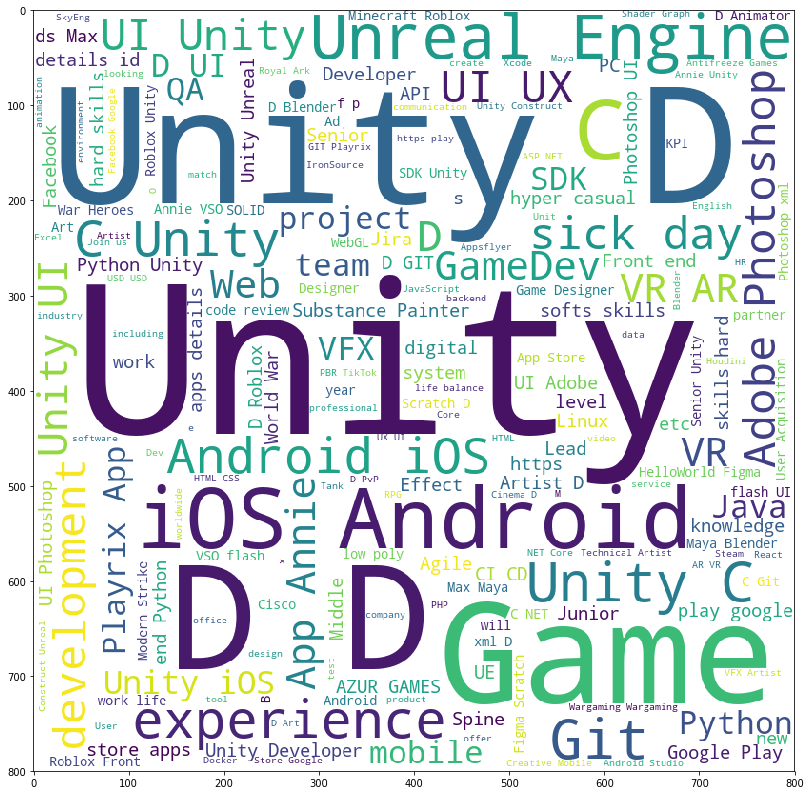

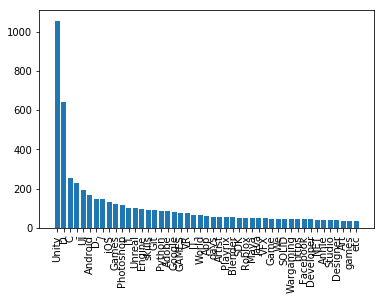

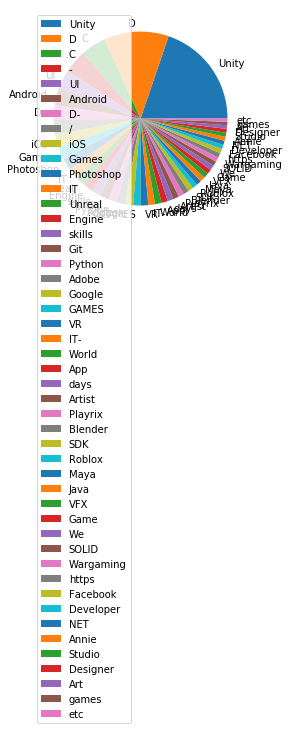

In [143]:
from collections import Counter
import scipy

vacancy_names = df.tag # change here to change source of data/words etc


descriptions = df.description

import re

additional_tegs = []

for dsc in descriptions:
    searched = re.findall(r"(([A-z]+[\s/-]*)+)+", dsc)
    for pair in searched: additional_tegs.append(list(pair)[0])

#print(additional_tegs)        
    
all_tags = []
for tag in vacancy_names:
    all_tags.append("".join(tag)) 



from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(additional_tegs):
    cloud+=x+' '

wordcloud = WordCloud(width = 800, height = 800, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (14, 14)) 
plt.imshow(wordcloud)
plt.savefig('vacancy_cloud.png')


import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))



ps = PorterStemmer()
stemmed_words=[]


for w in additional_tegs:
    words = word_tokenize(w)
    for wd in words: 
        if wd not in stop_words:
            stemmed_words.append(wd)
    
print(stemmed_words)


additional_tegs=stemmed_words
teg_frequencys = Counter(additional_tegs)
teg_frequencys = dict(teg_frequencys)

new_series = pd.Series(data=list(teg_frequencys), index=list(teg_frequencys.values()))
new_series=new_series.sort_index(ascending=False)

freq = dict(Counter(list(new_series.index)))
freq_values = list(freq.values())
freq_values.sort(reverse=True)

freq_median = scipy.median(freq_values)

new_index = []
for ind in list(freq):     
        if freq[ind]>scipy.median(freq_values):
            print(freq[ind],scipy.median(freq_values))
            new_index.append(ind)

          
        
#print(freq,"median",freq_values,freq_median,"mean",scipy.mean(freq_values),new_index)
new_series=new_series.drop(new_index)
#print(new_series)

from matplotlib import pyplot as plt

plt.figure()
plt.xticks(rotation='vertical')
plt.bar(new_series.values, new_series.index)
plt.show()


patches, texts = plt.pie(new_series.index, labels = new_series.values)
plt.legend(patches, new_series.values, loc="best")
plt.show()

In [113]:
! git add *
! git commit -m "fixed salary parsing"
! git push 

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[main fb3c89d] fixed salary parsing
 5 files changed, 13277 insertions(+), 8957 deletions(-)
 rewrite .ipynb_checkpoints/main-checkpoint.ipynb (73%)
 rewrite golang middle.csv (80%)
 rewrite main.ipynb (78%)
 rewrite vacancy_cloud.png (95%)


remote: This repository moved. Please use the new location:        
remote:   https://github.com/LuaSavage/hh_ru_parser.git        
To https://github.com/russianSlave/hh_ru_parser.git
   1a58342..fb3c89d  main -> main
